# Imports

In [57]:
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

2.9.1


# Feature Engineering

In [147]:
#read in the data
df = pd.read_csv('TSACheckinTS.csv')
df.head(5)

Unnamed: 0        Date  Checkins
0          99  2019-01-01   2202111
1          98  2019-01-02   2150571
2          97  2019-01-03   1975947
3          96  2019-01-04   2229391
4          95  2019-01-05   2044043

### Fast Fourier Transform

In [150]:
df.Date.describe()
df['Date'] = pd.to_datetime(df['Date'])

In [154]:
#create the trignonometric values for the data
timestamp_s = df.Date.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
month = 30*day
year = (365.25)*day

#daily frequencies
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
#monthly frequencies
df['month_sin'] = (np.sin(timestamp_s * (2*np.pi/month))).values
df['month_cos'] = (np.cos(timestamp_s * (2*np.pi/month))).values
#yearly frequencies
df['year_sin'] = (np.sin(timestamp_s * (2*np.pi/year))).values
df['year_cos'] = (np.cos(timestamp_s * (2*np.pi/year))).values

df.head()

Unnamed: 0       Date  Checkins       day_sin  day_cos  year_sin  year_cos  \
0          99 2019-01-01   2202111 -5.030095e-12      1.0 -0.004301  0.999991   
1          98 2019-01-02   2150571 -7.315560e-13      1.0  0.012901  0.999917   
2          97 2019-01-03   1975947 -1.098493e-11      1.0  0.030100  0.999547   
3          96 2019-01-04   2229391 -6.686394e-12      1.0  0.047289  0.998881   
4          95 2019-01-05   2044043 -2.387855e-12      1.0  0.064464  0.997920   

   month_sin  month_cos  
0  -0.406737  -0.913545  
1  -0.587785  -0.809017  
2  -0.743145  -0.669131  
3  -0.866025  -0.500000  
4  -0.951057  -0.309017

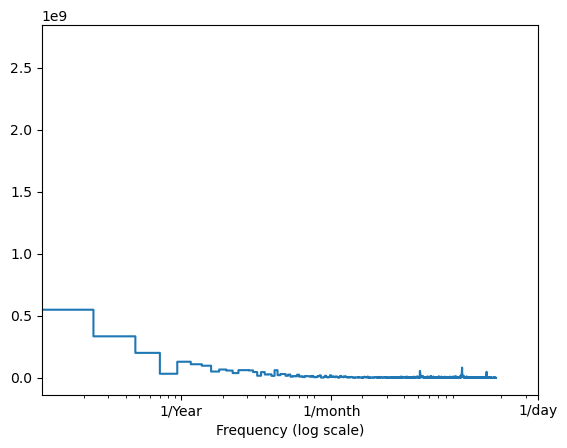

In [156]:
fft = tf.signal.rfft(df['Checkins'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Checkins'])
days_per_year = 365.25
years_per_dataset = n_samples_d/(days_per_year)
months_per_year = 12
months_per_dataset = years_per_dataset/months_per_year

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524], labels=['1/Year', '1/month','1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Splitting data

In [157]:
df = df.drop(['Date'], axis=1)
df.head()

Unnamed: 0  Checkins       day_sin  day_cos  year_sin  year_cos  month_sin  \
0          99   2202111 -5.030095e-12      1.0 -0.004301  0.999991  -0.406737   
1          98   2150571 -7.315560e-13      1.0  0.012901  0.999917  -0.587785   
2          97   1975947 -1.098493e-11      1.0  0.030100  0.999547  -0.743145   
3          96   2229391 -6.686394e-12      1.0  0.047289  0.998881  -0.866025   
4          95   2044043 -2.387855e-12      1.0  0.064464  0.997920  -0.951057   

   month_cos  
0  -0.913545  
1  -0.809017  
2  -0.669131  
3  -0.500000  
4  -0.309017

In [158]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((1089, 8), (311, 8), (156, 8))

In [159]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1089 non-null   int64  
 1   Checkins    1089 non-null   int64  
 2   day_sin     1089 non-null   float64
 3   day_cos     1089 non-null   float64
 4   year_sin    1089 non-null   float64
 5   year_cos    1089 non-null   float64
 6   month_sin   1089 non-null   float64
 7   month_cos   1089 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 68.2 KB


In [160]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

# Deep Learning Models

## `DataWindow` class 

In [193]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        #stores raw data
        self.train_df = train_df 
        self.val_df = val_df
        self.test_df = test_df
        #work out label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        #work out window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_to_input_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                        [labels[:,:,self.column_indices[name]] for name in self.label_columns], axis=-1
                    )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='Checkins', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n,1,n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker = '.', zorder=-10)
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (D)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                                 targets=None,
                                                                 sequence_length=self.total_window_size,
                                                                 sequence_stride=1,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 )
        ds = ds.map(self.split_to_input_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [69]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [51]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline Models

In [203]:
multi_window = DataWindow(input_width=30, label_width=30, shift=30, label_columns=['Checkins'])

### Repeat last value

In [204]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 30, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 30, 1])

In [205]:
baseline_last = MultiStepLastBaseline(label_index = column_indices['Checkins'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose = 0)

8/8 [==============================] - 0s 2ms/step - loss: 0.2167 - mean_absolute_error: 0.3775


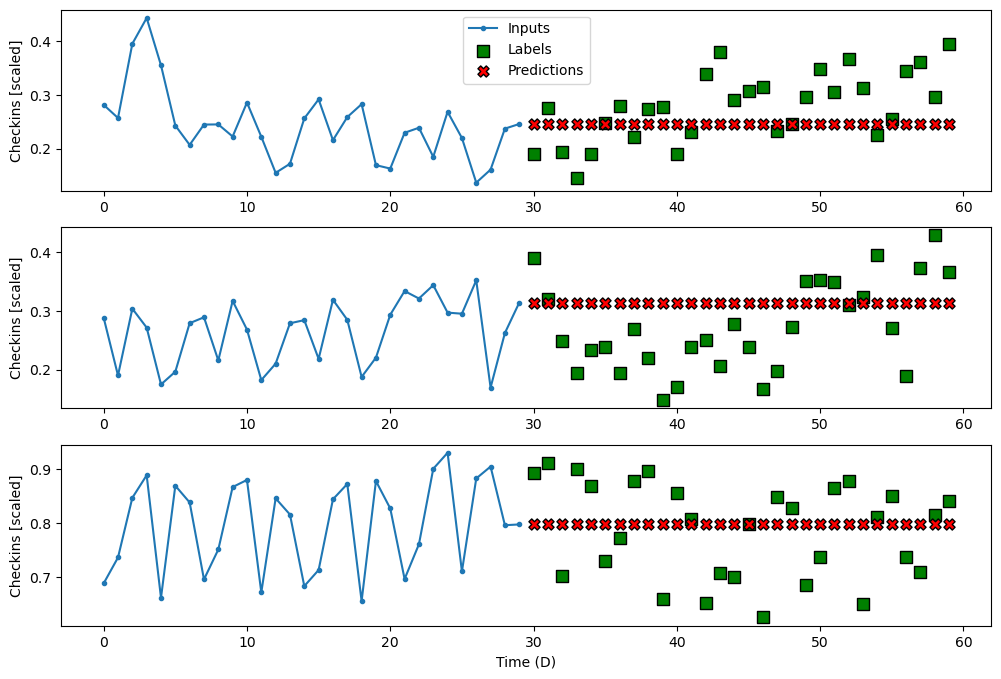

In [206]:
multi_window.plot(baseline_last)
plt.show()

### Repeat Last Day

In [190]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [191]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Checkins'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

8/8 [==============================] - 0s 2ms/step - loss: 0.2137 - mean_absolute_error: 0.3686


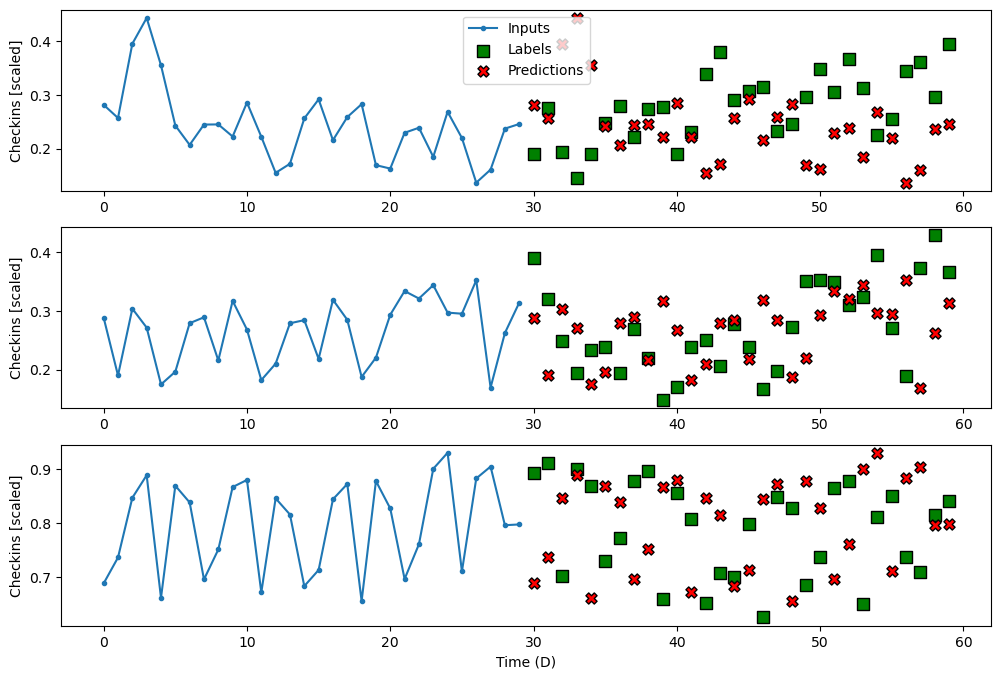

In [207]:
multi_window.plot(baseline_repeat)
plt.show()

With the repeat last day we can see that there is almost a monthly seasonality with checkins.  This is most noticeable with the third plot above.

### Linear Model

In [209]:
label_index = column_indices['Checkins']
num_features = train_df.shape[1]

linear = Sequential([Dense(1, kernel_initializer=tf.initializers.zeros)])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.2895 - mean_absolute_error: 0.4682 - val_loss: 0.3513 - val_mean_absolute_error: 0.5870
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.1797 - mean_absolute_error: 0.3578 - val_loss: 0.2178 - val_mean_absolute_error: 0.4579
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1179 - mean_absolute_error: 0.2927 - val_loss: 0.1364 - val_mean_absolute_error: 0.3563
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0873 - mean_absolute_error: 0.2563 - val_loss: 0.0920 - val_mean_absolute_error: 0.2860
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0743 - mean_absolute_error: 0.2375 - val_loss: 0.0682 - val_mean_absolute_error: 0.2404
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0689 - mean_absolute_error: 0.2271 - val_loss: 0.0560 - val_mean_absolute_error: 0.2147
Epoch 7/50
33/33 [=========

8/8 [==============================] - 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.1144


ValueError: Exception encountered when calling layer "sequential_8" (type Sequential).

Input 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (32, 30, 8)

Call arguments received by layer "sequential_8" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 30, 8), dtype=float32)
  • training=None
  • mask=None

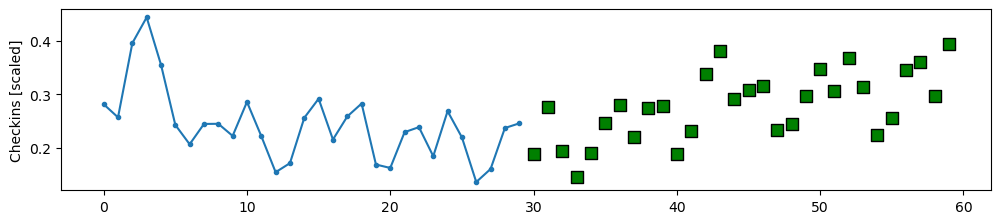

In [208]:
multi_window.plot(linear)
plt.show()

### CNN

In [212]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=30, label_columns=['Checkins'])

In [213]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
33/33 [==============================] - 2s 11ms/step - loss: 0.2223 - mean_absolute_error: 0.3939 - val_loss: 0.0366 - val_mean_absolute_error: 0.1599
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0625 - mean_absolute_error: 0.2051 - val_loss: 0.0240 - val_mean_absolute_error: 0.1313
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0361 - mean_absolute_error: 0.1534 - val_loss: 0.0191 - val_mean_absolute_error: 0.1137
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0237 - mean_absolute_error: 0.1166 - val_loss: 0.0154 - val_mean_absolute_error: 0.0963
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0214 - mean_absolute_error: 0.1035 - val_loss: 0.0111 - val_mean_absolute_error: 0.0798
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0215 - mean_absolute_error: 0.1023 - val_loss: 0.0121 - val_mean_absolute_error: 0.0833
Epoch 7/50
33/33 [=========

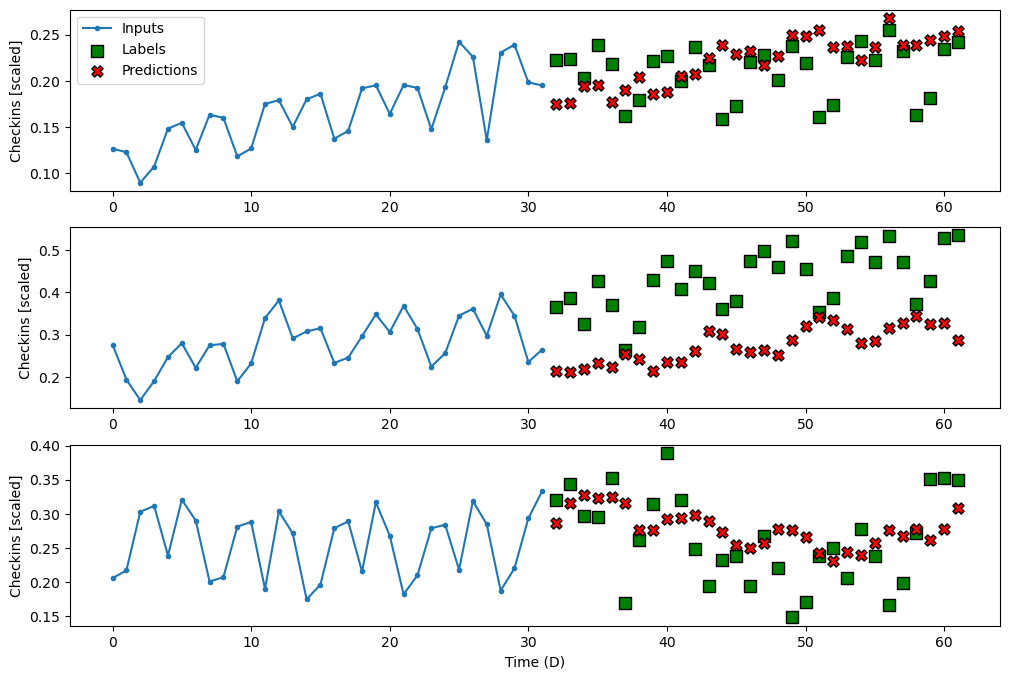

In [214]:
cnn_multi_window.plot(cnn_model)

plt.show()

The first plot seems to capture the trend that checkins increase as the month progresses

### CNN + LSTM

Combined Convolutional Neural Network and Long Short Term Memory.  The CNN part interprets the subseqeunces into a sequence which is then interpreted by the LSTM model.

In [215]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
33/33 [==============================] - 4s 31ms/step - loss: 0.2056 - mean_absolute_error: 0.3799 - val_loss: 0.0316 - val_mean_absolute_error: 0.1217
Epoch 2/50
33/33 [==============================] - 1s 15ms/step - loss: 0.0831 - mean_absolute_error: 0.2448 - val_loss: 0.0448 - val_mean_absolute_error: 0.1822
Epoch 3/50
33/33 [==============================] - 1s 15ms/step - loss: 0.0568 - mean_absolute_error: 0.1969 - val_loss: 0.0352 - val_mean_absolute_error: 0.1498
Epoch 4/50
33/33 [==============================] - 1s 15ms/step - loss: 0.0329 - mean_absolute_error: 0.1332 - val_loss: 0.0238 - val_mean_absolute_error: 0.1129
Epoch 5/50
33/33 [==============================] - 1s 16ms/step - loss: 0.0273 - mean_absolute_error: 0.1160 - val_loss: 0.0221 - val_mean_absolute_error: 0.1131
Epoch 6/50
33/33 [==============================] - 1s 15ms/step - loss: 0.0258 - mean_absolute_error: 0.1128 - val_loss: 0.0148 - val_mean_absolute_error: 0.0916
Epoch 7/50
33/33 [====

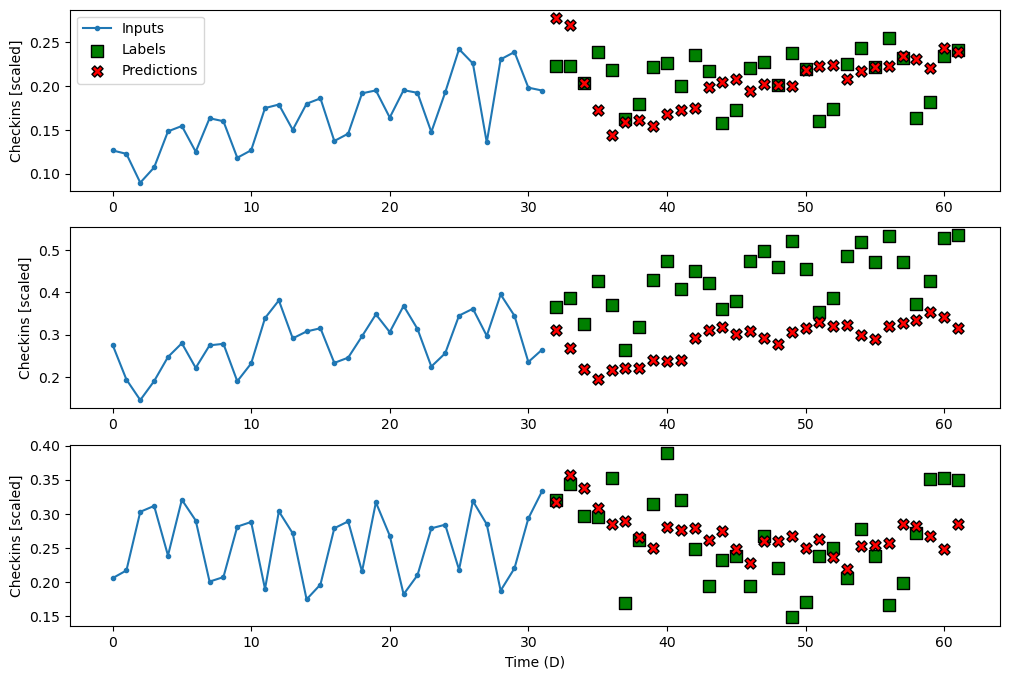

In [216]:
cnn_multi_window.plot(cnn_lstm_model)

plt.show()

## Analysis

Here we can compare all the different models by their mean value score for the validation and test sets.

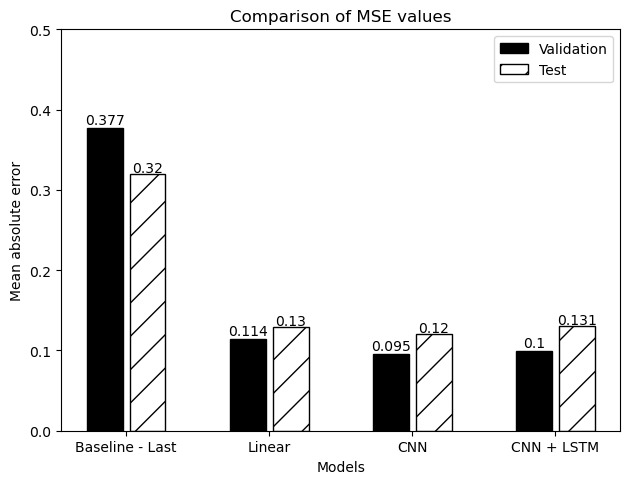

In [217]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.50)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()
plt.title('Comparison of MSE values')

plt.show()

We see that the CNN and linear models have the lowest MSE values while the Baseline models have much higher MSE values.  